# Explosive Narratives: Terrorism through the Cinematic Lens
## Boat2023 Milestone 2

In this preparatory part of the project, we agreed on our project proposal; the impact on terrorism on cinema. We performed initial analyses including data exploration, data pre-processing and initial data visualizations, all in relation to our research questions: emotional depiction of terrorism-related movies, genre association, topic analysis as well as popularity.

In [1]:
from helpers import *

#useful imports
import xml.etree.ElementTree as ET
import pandas as pd
from typing import Dict
import json
import re

#important libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf


#important libraries for the Sentiment analysis
from scipy.signal import savgol_filter
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

FILE_ID = '1UKCPLE0QpJGDncD6zvXfSIil0pRlCj-c'
LOCAL_FILE_NAME='local_title_data.tsv'

ImportError: cannot import name 'is_ascii' from 'charset_normalizer.utils' (/Users/macdesarah/opt/anaconda3/envs/ADA/lib/python3.9/site-packages/charset_normalizer/utils.py)

In [4]:
download_data(FILE_ID,LOCAL_FILE_NAME)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UKCPLE0QpJGDncD6zvXfSIil0pRlCj-c
From (redirected): https://drive.google.com/uc?id=1UKCPLE0QpJGDncD6zvXfSIil0pRlCj-c&confirm=t&uuid=06a926d6-4e9c-483b-9148-2c1240a0a100
To: /Users/aishamasmoudi/Desktop/4567234567890'/P2/ada-2023-project-boat2023/local_title_data.tsv
100%|██████████| 885M/885M [01:27<00:00, 10.1MB/s] 


## 1. Data Pre-processing

### 1.1 Import Data

In [2]:
plot_path= 'data/plot_summaries.txt'
movie_metadata_path = 'data/movie.metadata.tsv'
external_title_path= LOCAL_FILE_NAME
external_rating_path= 'data/data.tsv'

In [8]:
m_plot = pd.read_csv(plot_path, delimiter='\t', header= None)
m_column_names = ['W_movie ID', 'F_movie ID', 'Movie name', 'Release date', 'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
m_data = pd.read_csv('data/movie.metadata.tsv', delimiter= '\t',on_bad_lines='skip', names=m_column_names, header=0)
rating_data=pd.read_csv(external_rating_path,delimiter='\t', on_bad_lines='skip', header=0)
external_title= pd.read_csv(external_title_path,delimiter='\t', on_bad_lines='skip', header=0)

/var/folders/f6/p2jq7zvd7jq9y5mvqb6p1wlh0000gn/T/ipykernel_41061/2205135396.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  external_title= pd.read_csv(external_title_path,delimiter='\t', on_bad_lines='skip', header=0)


In [ ]:
m_data.head(5)

When displaying the dataframe, we notice that the columns Countries, Languages and Genres include some kind of ID, in addition to the readable value we are interest in (for example {"/m/0chghy": "Australia"}). To get a more visually pleasing dataframe, we use the JSON library as follows.

In [ ]:
# Function to extract the readable values from the strings
def extract_values(text):
    try:
        # Load the text as JSON and extract values
        data_dict = json.loads(text)
        return ', '.join(data_dict.values())
    except json.JSONDecodeError:
        # If it's not valid JSON, try to find all readable parts with regex
        return ', '.join(re.findall(r'":\s*"([^"]+)"', text))

# Apply the function to clean the columns of our dataframe
m_data['Countries'] = m_data['Countries'].apply(extract_values)
m_data['Languages'] = m_data['Languages'].apply(extract_values)
m_data['Genres'] = m_data['Genres'].apply(extract_values)
display(m_data)

### 1.2 Filter Terrorism-Related Movies and Other Movies

Since our research focuses on the impact of terrorism on movies, we need to filter the dataset to solely target movies related to terrorism. We did some research and crafted a list of keywords of the terrorism lexicon, mainly based on information from Wikipedia. We used this list to create a subset of our original dataset, that we will use for all our analyses.

In [ ]:
KEYWORDS = [ "Terrorism", "Terrorist", "Terrorists", "Jihad", "Extremism", "Extremist", "Attacks", "Attack", "Bombs", "Bombing", "Bombers", 
            "Hijack", "Hijacking", "Kidnap", "Kidnapping", "Counterterrorism", "Counterterrorist", "Radicalization", "Radicalized", 
            "Security Threat", "Political Violence", "Suicide Bomber", "War on Terror", "Homeland Security", "National Security", "Intelligence Agencies", 
            "Counterinsurgency", "Terrorist Cells", "Radical Ideology", "Terrorist Plot", "Terrorist Organization", "Hostage Crisis", "Terrorism Investigation", 
            "Counterterrorist Operation", "Radical", "Guerrilla Warfare", "Insurgency", "Terror Threat", "Covert Operations", "Political Unrest", "Martyrdom", 
            "Cyberterrorism", "Terrorism Financing", "Violent Extremism", "Terrorist Recruitment", "Suicide Attacks", "Terrorist Sleeper Cells", 
            "Counterterror Measures", "Clandestine Activities", "Security Intelligence" ]

In [9]:
movie_ids=[]
# Create a new column in the DataFrame to store the count of keywords in each movie plot
for index, row in m_plot.iterrows():
    movie_id = row[0]
    plot = row[1]
    # Check if the plot contains any of the keywords
    for keyword in KEYWORDS:
        if keyword.lower() in plot:
            movie_ids.append(movie_id)
# Display the list of movie IDs that match the keywords
movie_ids= set(movie_ids)

In [10]:
# Terrorism-related movies
terrorism_movies = m_data[m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]
terrorism_movies = terrorism_movies.sort_values(by=['Release date'])
display(terrorism_movies) 

In [ ]:
#Keeping all the movies with box office
revenue_data = m_data.dropna(subset=['Box office revenue'])
#Keeping terrorism movies with box office
other_movies= revenue_data[~revenue_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]

In [11]:
df_plot = m_plot.rename(columns={0: 'W_movie ID', 1: 'summary'})
df_for_topics = pd.merge(terrorism_movies, df_plot, on='W_movie ID', how='inner')
df_for_topics.drop('Box office revenue', axis =1, inplace=True)
df_for_topics.head(3)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary
0,9633533,Vandanam,1989,"{""/m/03rk0"": ""India""}","{""/m/0999q"": ""Malayalam Language""}","{""/m/02kdv5l"": ""Action""}","Professor Kurian Fernandez , a convict escapes..."
1,261237,The Gods Must Be Crazy,1980,"{""/m/0hzlz"": ""South Africa""}","{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...
2,4951456,Kinjite: Forbidden Subjects,1989,"{""/m/09c7w0"": ""United States of America""}","{""/m/02h40lc"": ""English Language""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",A Japanese businessman sees a woman being grop...


### 1.3 Remove Nan Values

In [12]:
terrorism_movies = terrorism_movies.sort_values(by=['Release date'])
terrorism_movies['Release date']=  terrorism_movies['Release date'].str[:4]
terrorism_movies.dropna(subset=['Release date'], inplace=True)

## 2.Data wrangling

In [13]:
other_movies = other_movies.sort_values(by=['Release date'])
other_movies['Release date']=  other_movies['Release date'].str[:4]
other_movies.dropna(subset=['Release date'], inplace=True)

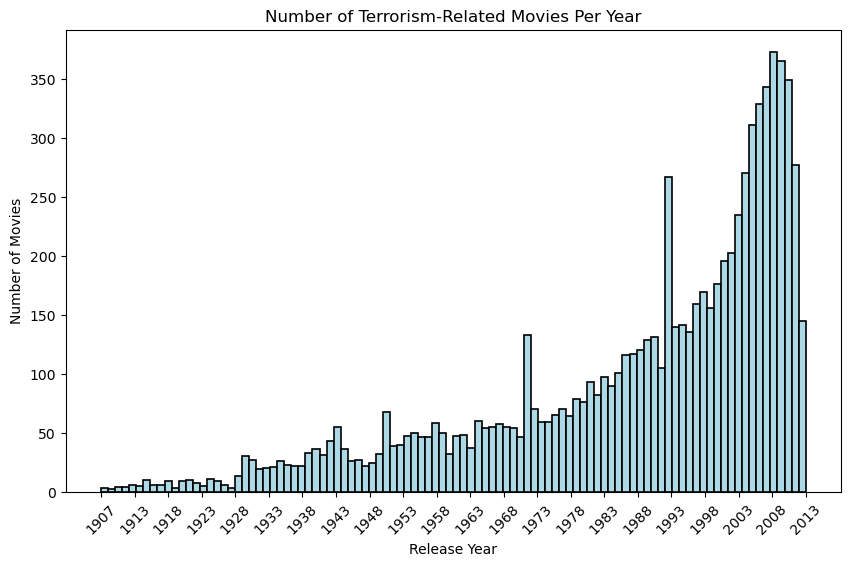

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(terrorism_movies['Release date'],bins= 100, linewidth=1.2, edgecolor='black', color='lightblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
min_year = int(terrorism_movies['Release date'].min())
max_year = int(terrorism_movies['Release date'].max())
plt.title('Number of Terrorism-Related Movies Per Year')
ax.set_xticks(ax.get_xticks()[::5])
plt.xticks(rotation=45)
plt.show()


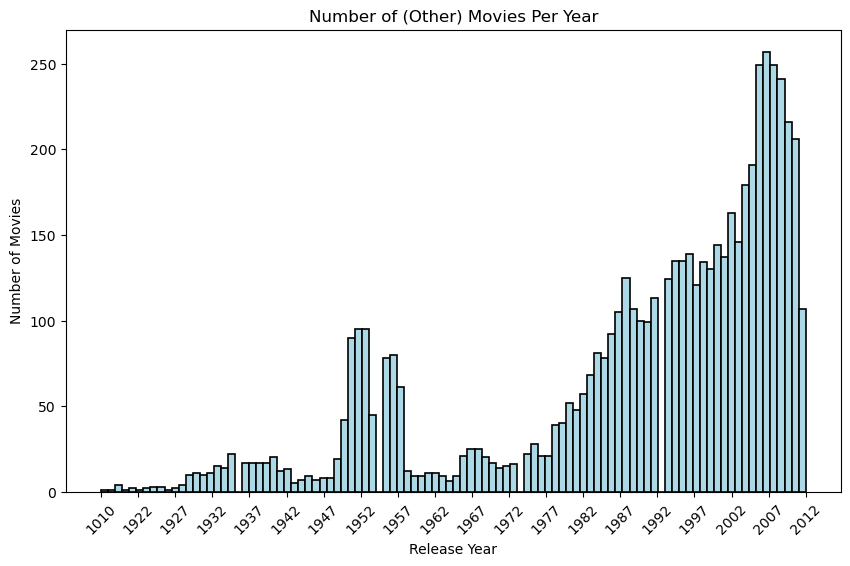

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(other_movies['Release date'],bins= 100, linewidth=1.2, edgecolor='black', color='lightblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
min_year = int(terrorism_movies['Release date'].min())
max_year = int(terrorism_movies['Release date'].max())
plt.title('Number of (Other) Movies Per Year')
ax.set_xticks(ax.get_xticks()[::5])
plt.xticks(rotation=45)
plt.show()


# Are there specific genres associated to terrorism movies?

Each movie is associated with various genres. The genre of a movie is a way to categorize it. It reflects the movie’s narrative elements, thematic content, stylistic approach, and the emotional response it aims to evoke in the audience. It allows audiences and film-makers to understand the type of content they can expect from a movie. 

Below, we describe each method that we will be using to analyze the association between genres and terrorism movies.
For each method, we describe what the method does, why it is interesting in the context of genres and terrorism movies and how it works.
We also do the necessary data pre-processing for each method, as well as the first visualizations.

The analysis in in three parts: Frequency analysis, heatmap of counts of movies of certain genres of different countries, and a chi-squared independence test.

## 1. Frequency Analysis
__What It Does__: Frequency analysis counts how often each genre appears in movies about terrorism vs in non-terrorism movies.

__Why It’s Interesting__: This method would provide a clear, quantitative measure of the association between genres and terrorism-themed movies. It could reveal if terrorism movies are associated with certain genres, like action or drama.

__How It Works__: We first filter our dataset for movies that are classified as related to terrorism. We do this by keyword search within movie descriptions. We define a list of keywords that are associated with terrorism, then only keep the movies whose plot contains at least one of these keywords. Then, we count the frequency of each genre within this subset and compare it to the overall frequency of genres in the entire dataset.

__Data Pre-Processing and Visualization__: We need to write a code that allows to count the genres. We also do a visualization of the top 10 most common genres in non-terrorism movies vs in terrorism-related movies.

We want to compare the frequency of genres between terrorism-related movies and non-terrorism-related movies.

In [17]:
non_terrorism_movies = m_data[~m_data['W_movie ID'].isin(movie_ids)]
display(len(terrorism_movies))
display(len(non_terrorism_movies))

8289

73114

In the data set without terrorism-related movies (other_movies), we have 74114 movies.
In the filtered data set (terrorism_movies), we have 8626 movies, which correspond to terrorism-related movies.

In [18]:
display(non_terrorism_movies.head())

,W_movie ID,F_movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."


In [19]:
display(terrorism_movies.head())

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue
42214,32986669,Robbery Under Arms,1907,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",NaN
64189,7870349,Dr. Jekyll and Mr. Hyde,1908,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
70994,29391146,The Black Viper,1908,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film""}",NaN
18652,28777800,The Englishman and the Girl,1910,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
45311,13254122,What the Daisy Said,1910,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN


Now, we start the genre analysis. We want to take a look at the top 10 most common genres in both terrorism-related movies (terrorism_movies) and non-terrorism-related movies.

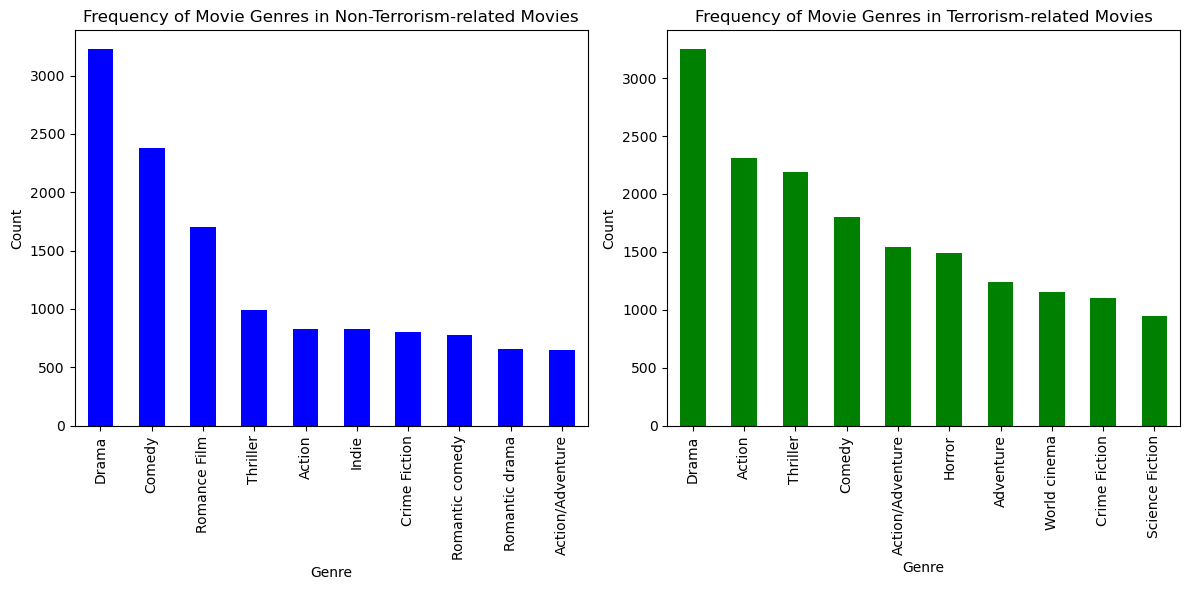

In [20]:
#Define a function to parse the genre column
def parse_genre(genre_str):
    try:
        # Convert the string representation of a dictionary into an actual dictionary
        genre_dict = ast.literal_eval(genre_str)
        # Return the values (genres) of the dictionary
        return list(genre_dict.values())
    except ValueError:
        # In case of any parsing error, return an empty list
        return []

## Non-terrorism movies

#Apply the function to each row in the genre column and flatten the list of lists
genres_series = other_movies['Genres'].apply(parse_genre)
all_genres = [genre for sublist in genres_series for genre in sublist]

#Create a frequency count of each genre
genre_counts = pd.Series(all_genres).value_counts()

#Only keep the top 10 most common genres
top_10_non_terrorism_movies = genre_counts.nlargest(10)

## Terrorism-related movies

#Apply the function to each row in the genre column and flatten the list of lists
genres_series = terrorism_movies['Genres'].apply(parse_genre)
all_genres = [genre for sublist in genres_series for genre in sublist]

#Create a frequency count of each genre
genre_counts = pd.Series(all_genres).value_counts()

#Only keep the genres that are present in more than 1000 movies
top_10_terrorism_movies = genre_counts.nlargest(10)

#Plot the barplots of movie genres for terrorism vs non-terrorism-related movies
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

top_10_non_terrorism_movies.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Frequency of Movie Genres in Non-Terrorism-related Movies')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')

top_10_terrorism_movies.plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Frequency of Movie Genres in Terrorism-related Movies')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Genre')

plt.tight_layout()
plt.show()

## 2. Heatmap of genres of terrorism movies between different countries

__What It Does__: The heatmap will show the counts of movies of each genre for each country.

__Why It’s Interesting__: This method would provide a qualitative measure of the association between genres of terrorism-themed and countries. It could reveal if terrorism movies in the USA of the United Kingdom are associated with certain genres, like action or drama, etc.

__How It Works__: We look for the 10 countries that have the most terrorism-related movies. We create a matrix where each cell contains the count of movies for a particular genre in a particular country. Since we are only intered in these 10 countries, we filter the matrix to inclue just those. Then we plot the heatmap from the matrix.

__Data Pre-Processing and Visualization__: To prepare our data, we need to ensure that the dataset is structured so that each movie has a genre list and an associated country.

First, let's start by identifying the 10 countries that have the most terrorism-related movies.

Text(0, 0.5, 'Movies')

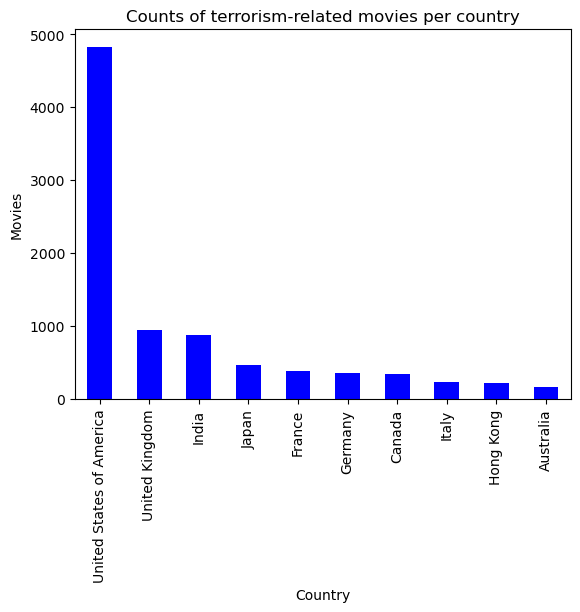

In [21]:
#Define a function to parse the 'Countries' column
def parse_countries(countries_str):
    try:
        # Convert the string representation of a dictionary into an actual dictionary
        countries_dict = ast.literal_eval(countries_str)
        # Return the values (country names) of the dictionary
        return list(countries_dict.values())
    except ValueError as e:
        # In case of any parsing error, return an empty list
        return []

#Apply the function to each row in the 'Countries' column
# This will create a Series of lists
countries_series = terrorism_movies['Countries'].apply(parse_countries)

#Explode the lists into separate rows
exploded_countries = countries_series.explode()

#Count the occurrences of each country
country_counts = exploded_countries.value_counts()

#Only keep the 10 countries that have the most movies
country_counts = country_counts.nlargest(10)

plt.figure()
country_counts.plot(kind='bar', color='blue')
plt.title('Counts of terrorism-related movies per country')
plt.xlabel('Country')
plt.ylabel('Movies')

These 10 countries are: United States of America, United Kingdom, India, Japan, France, Germany, Canada, Italy, Hong Kong, Australia.

We process the Languages, Countries and Genres columns in the terrorism_movies DataFrame that contain JSON-like strings. We convert the strings in these columns into Python lists containing the values from the JSON object

In [22]:
json_cols = ["Languages", "Countries", "Genres"]
list_terrorism_movies = terrorism_movies.copy()
for col in json_cols:
    list_terrorism_movies[col] = list_terrorism_movies[col].apply(lambda x: list(json.loads(x).values()))

Now, we only keep the movies that are from at least one of the 10 countries mentioned before, and that have at least one genre from the 10 genres mentioned before.

In [27]:
#Define a function that checks whether a list of countries contains at least one of the 10 countries we are interested in
def contains_countries_of_interest(lst):
    # List of countries of interest
    countries_of_interest = [
        "United States of America", "United Kingdom", "India", "Japan",
        "France", "Germany", "Canada", "Italy", "Hong Kong", "Australia"]
    return any(country in countries_of_interest for country in lst)

#Define a function that checks whether a list of genres contains at least one of the 10 genres we are interested in
def contains_genres_of_interest(lst):
    # List of countries of interest
    genres_of_interest = ['Drama', 'Action', 'Thriller', 'Comedy', 'Action/Adventure', 'Horror',
                          'Adventure', 'World cinema', 'Crime Fiction', 'Science Fiction']
    return any(genre in genres_of_interest for genre in lst)

temp = list_terrorism_movies[list_terrorism_movies['Countries'].apply(contains_countries_of_interest)]
movies_of_interest = temp[temp['Genres'].apply(contains_genres_of_interest)]
movies_of_interest

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue
42214,32986669,Robbery Under Arms,1907,[Australia],[Silent film],"[Silent film, Drama]",NaN
64189,7870349,Dr. Jekyll and Mr. Hyde,1908,[United States of America],[Silent film],"[Short Film, Silent film, Horror, Indie, Black...",NaN
18652,28777800,The Englishman and the Girl,1910,[United States of America],"[Silent film, English Language]","[Short Film, Silent film, Comedy]",NaN
45311,13254122,What the Daisy Said,1910,[United States of America],"[Silent film, English Language]","[Short Film, Silent film, Drama, Indie, Black-...",NaN
26378,7126772,Aerial Anarchists,1911,[United Kingdom],"[Silent film, English Language]","[Short Film, Science Fiction, Silent film, Ind...",NaN
...,...,...,...,...,...,...,...
24122,35625635,Chakravyuh,2012,[India],[Hindi Language],"[Action, Drama, Political thriller]",NaN
40367,34953010,Zero Dark Thirty,2012,[United States of America],[English Language],"[Thriller, Action, Drama]",NaN
3303,32258845,Pain & Gain,2013,[United States of America],[],"[Comedy film, Action, Drama]",NaN
32374,35627063,The Smurfs 2,2013,[United States of America],[],"[Family Film, Fantasy, Comedy, Animation]",NaN


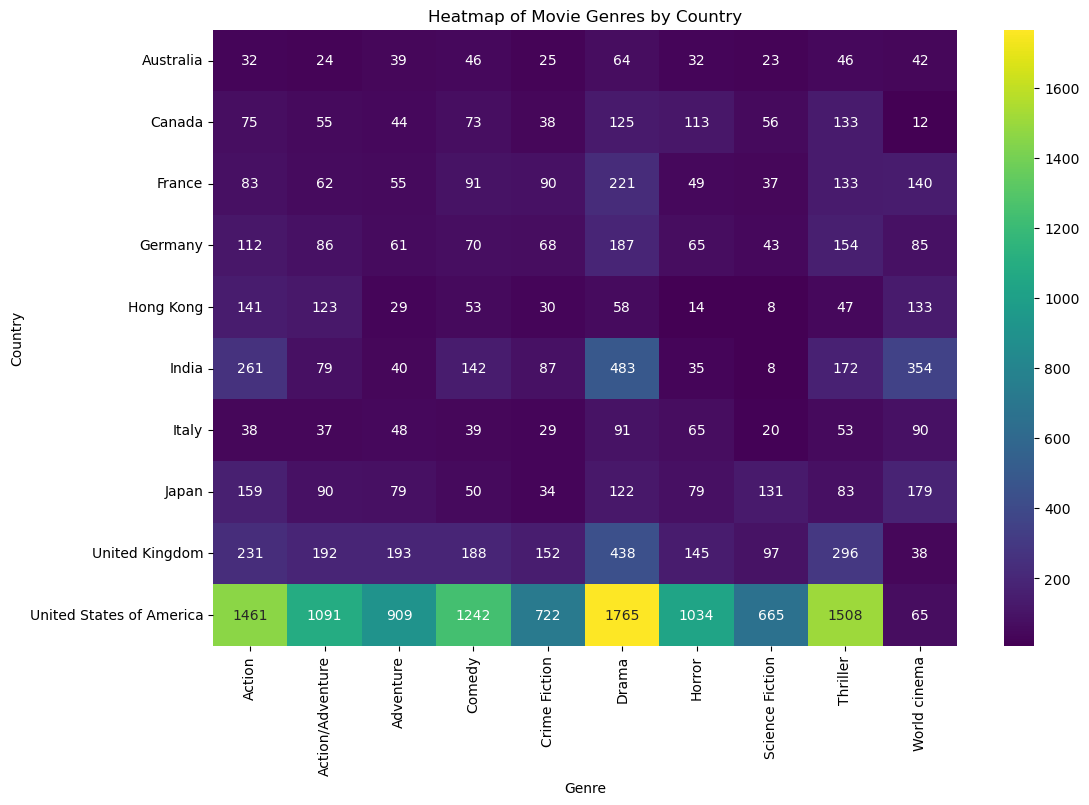

In [28]:
#Explode the data frame twice w.r.t. Countries and Genres
exploded_data = movies_of_interest.explode('Countries').explode('Genres')

#Define the countries of interest
countries_of_interest = [
        "United States of America", "United Kingdom", "India", "Japan",
        "France", "Germany", "Canada", "Italy", "Hong Kong", "Australia"]

#Define the genres of interest
genres_of_interest = ['Drama', 'Action', 'Thriller', 'Comedy', 'Action/Adventure', 'Horror',
                          'Adventure', 'World cinema', 'Crime Fiction', 'Science Fiction']

#Only keep elements of the exploded data that have one of the countries of interest and one of the genres of itnerest
temp = exploded_data[
    exploded_data['Countries'].isin(countries_of_interest) & 
    exploded_data['Genres'].isin(genres_of_interest)]

# Create a pivot table with countries as rows, genres as columns, and counts as values
heatmap_set = pd.pivot_table(temp, index='Countries', columns='Genres', aggfunc='size', fill_value=0)

#Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_set, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Movie Genres by Country')
plt.xlabel('Genre')
plt.ylabel('Country')
plt.show()

As we can see, since there are a lot more movies from the USA, we can't really see the variation between genres for the rest of the countries. 
Therefore, we decided to check out the genre frequency of the USA movies alone, and repeat the analysis for the rest of the countries.

First, let's remove the USA from list of countries of interest.

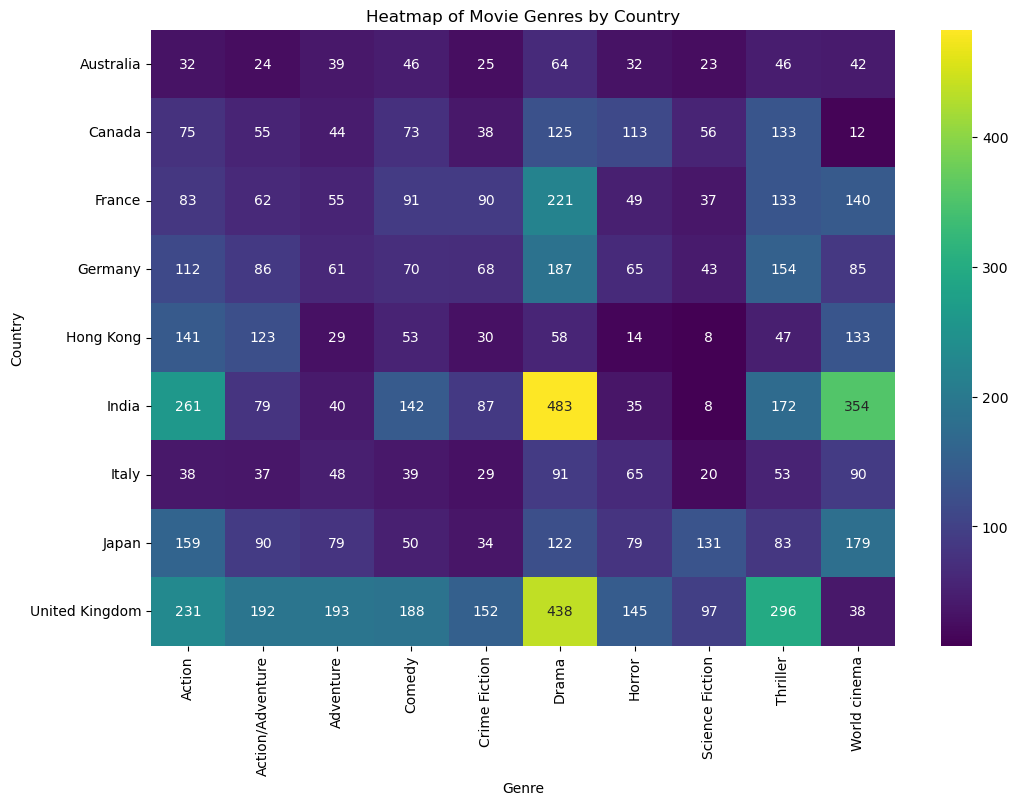

In [29]:
countries_of_interest = [
        "United Kingdom", "India", "Japan",
        "France", "Germany", "Canada", "Italy", "Hong Kong", "Australia"]

temp = exploded_data[
    exploded_data['Countries'].isin(countries_of_interest) & 
    exploded_data['Genres'].isin(genres_of_interest)]

# Create a pivot table with countries as rows, genres as columns, and counts as values
heatmap_set = pd.pivot_table(temp, index='Countries', columns='Genres', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_set, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Movie Genres by Country')
plt.xlabel('Genre')
plt.ylabel('Country')
plt.show()

Now, let's do the analysis for the USA alone.

Text(0, 0.5, 'Movies')

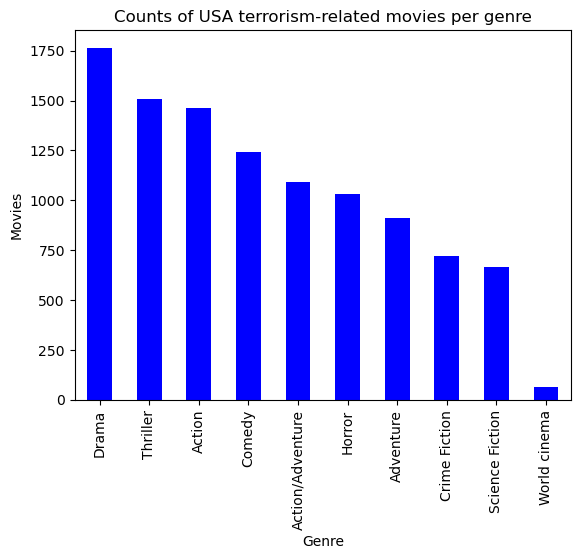

In [30]:
temp = exploded_data[exploded_data['Countries'] == 'United States of America']
temp = temp[temp['Genres'].isin(genres_of_interest)]

#Count the occurrences of each country
genre_counts = temp['Genres'].value_counts()

plt.figure()
genre_counts.plot(kind='bar', color='blue')
plt.title('Counts of USA terrorism-related movies per genre')
plt.xlabel('Genre')
plt.ylabel('Movies')

As we can notice, except for Hong Kong and Japan, the most prevalent genre is Drama. In the part about sentimental analysis, it could be interesting to only focus on the Drama movies and see whether the way each country depicts its Drama terrorism-related movies is different, sentimental-wise.

## 3. Chi-Square Test of Independence
__What It Does__: Tests whether there is a significant association between movie genres and their portrayal of terrorism.

__Why It’s Interesting__: This statistical test can validate whether any observed association between genres and terrorism portrayal is statistically significant, rather than due to random chance.

__How It Works__: The Chi-Square test will tell you whether the distribution of genres in terrorism-related movies is different from what would be expected if there was no association between genre and terrorism content.

__Data Pre-Processing Needed__: You will need a table where one column is genres and the other is a binary variable indicating whether the movie is terrorism-related.

First, we create a new column for the feature Terrorism-related. This feature is binary. Its value is 1 if the movie is terrorism-related, and it is 0 if it is not.

In [31]:
m_data_chi = m_data.copy()
m_data_chi['Terrorism-related'] = m_data['W_movie ID'].apply(lambda x: 1 if x in movie_ids else 0)

m_data_chi['Release year'] = m_data_chi['Release date'].str[:4]
m_data_chi.drop(columns=['F_movie ID','Box office revenue', 'Runtime', 'Release date'], axis=1, inplace=True)

Now, we process the Genres columns in the m_data_chi DataFrame that contain JSON-like strings. We convert the strings in these columns into Python lists containing the values from the JSON object.

In [32]:
json_cols = ["Genres"]
for col in json_cols:
    m_data_chi[col] = m_data_chi[col].apply(lambda x: list(json.loads(x).values()))

Finally, we create the chi-square test data that is a table where one column is the Genre and the other is the Terrorism-related binary variable.

In [33]:
exploded_data = m_data_chi.explode('Genres')
chi_square_data = exploded_data[['Genres', 'Terrorism-related']]
chi_square_data.head()

,Genres,Terrorism-related
0,Mystery,0
0,Biographical film,0
0,Drama,0
0,Crime Drama,0
1,Crime Fiction,0


### **2.1 How popular are terrorism-related movies in comparison to others?**

#### 4.1.1 Statistics of Box Office Collections & Visualizations

<function matplotlib.pyplot.show(close=None, block=None)>

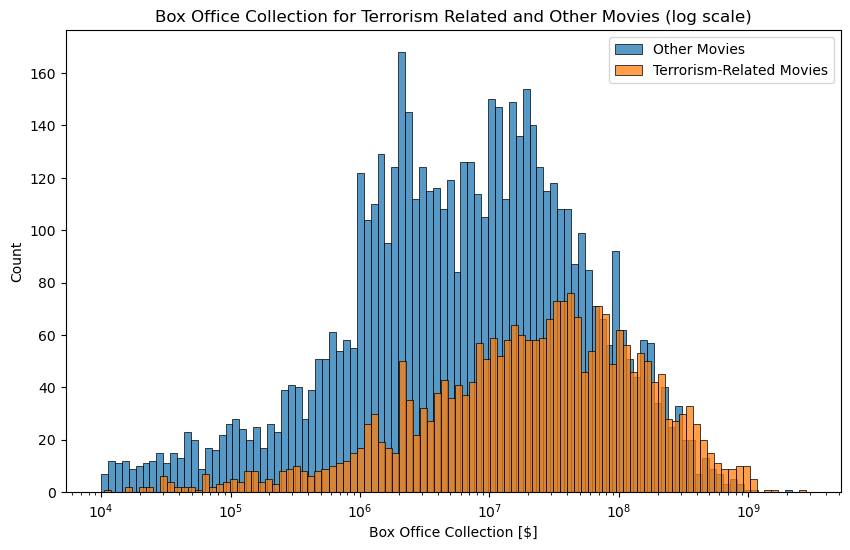

In [12]:
other_movies = other_movies.dropna(subset=['Box office revenue'])

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(other_movies['Box office revenue'], bins=100, log_scale=True, label='Other Movies')
sns.histplot(terrorism_movies['Box office revenue'], bins=100, log_scale=True, label= 'Terrorism-Related Movies')
plt.title('Box Office Collection for Terrorism Related and Other Movies (log scale)')
plt.xlabel('Box Office Collection [$]')
plt.legend()
plt.show


We observed that the box office revenue distribution exhibits a heavy tail. Consequently, rather than focusing on the mean, 23 consider the log-transformed values of the box office collection.

In [13]:
terro_log_revenue= np.log1p(terrorism_movies['Box office revenue'])
others_log_revenue= np.log1p(other_movies['Box office revenue'])

terror_log_revenue_mean= terro_log_revenue.mean()
others_log_revenue_mean= others_log_revenue.mean()

print(terror_log_revenue_mean)
print(others_log_revenue_mean)

16.824938751643955
15.624203760130868


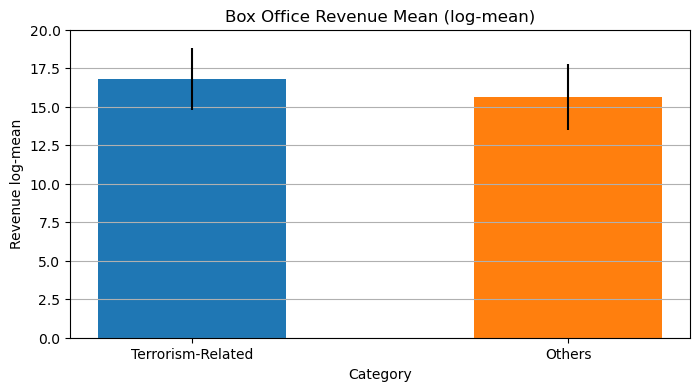

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
categories= ['Terrorism-Related','Others']
log_means= [terror_log_revenue_mean,others_log_revenue_mean]
uncertainties = [np.std(terro_log_revenue, ddof=1), np.std(others_log_revenue, ddof=1)]


for i in range(2):
    plt.bar(categories[i], log_means[i], yerr=uncertainties[i], width=0.5)
#plt.bar(, terror_log_revenue_mean)
#plt.bar(, others_log_revenue_mean)
plt.title('Box Office Revenue Mean (log-mean)')
plt.ylabel('Revenue log-mean')
ax.yaxis.grid(True)
plt.xlabel('Category')
plt.ylim([0,20])
plt.show()

In [15]:
print("Statistics of 'Other Movies' box office collections:")
other_movies['Box office revenue'].describe()

Statistics of 'Other Movies' box office collections:


count    5.808000e+03
mean     3.330517e+07
std      8.092528e+07
min      1.000000e+04
25%      1.600000e+06
50%      7.030036e+06
75%      2.755939e+07
max      2.185372e+09
Name: Box office revenue, dtype: float64

In [16]:
print("Statistics of 'Terrorism-related Movies' box office collections:")
terrorism_movies['Box office revenue'].describe()

Statistics of 'Terrorism-related Movies' box office collections:


count    2.519000e+03
mean     8.276545e+07
std      1.581620e+08
min      1.051400e+04
25%      6.106830e+06
50%      2.618663e+07
75%      8.553192e+07
max      2.782275e+09
Name: Box office revenue, dtype: float64

#### 4.1.2 Rating

In [17]:
other_movies= m_data[~m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Box office revenue']]
terrorsim_movies= m_data[m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Box office revenue']]

In [18]:
#extract only movie related information
external_title = external_title[external_title['titleType'] == 'movie']
#merge the rating_data with external_title data on 'tconst'
merge_title_rating= pd.merge(rating_data,external_title,left_on='tconst', right_on='tconst', how='inner')

In [19]:
other_merged= pd.merge(other_movies,merge_title_rating, left_on='Movie name', right_on='originalTitle', how='inner')
other_merged= other_merged.drop_duplicates(subset=['Movie name'])

In [20]:
terrorism_merged= pd.merge(terrorism_movies,merge_title_rating, left_on='Movie name', right_on='originalTitle', how='inner')
terrorism_merged= terrorism_merged.drop_duplicates(subset=['Movie name'])

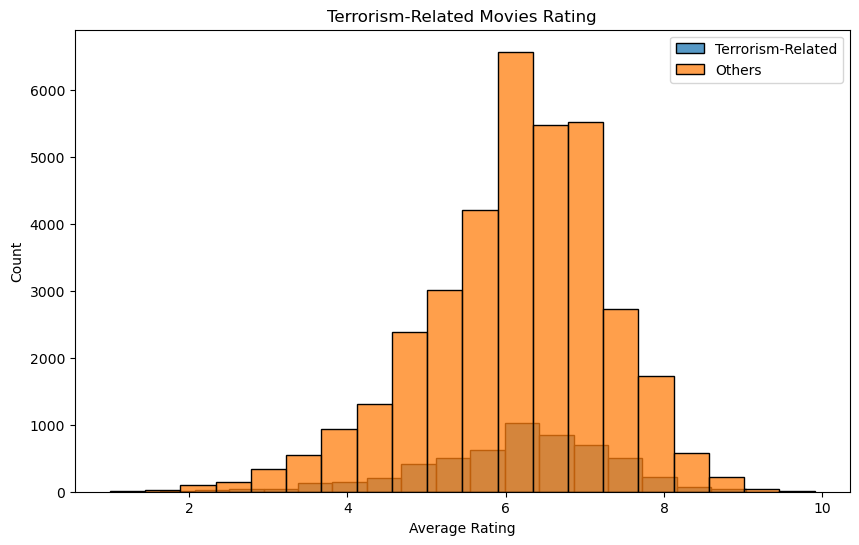

In [21]:
fig, ax = plt. subplots(figsize= (10,6))
sns.histplot(terrorism_merged['averageRating'], bins=20, label='Terrorism-Related')
sns.histplot(other_merged['averageRating'], bins=20, label= 'Others')
plt.title('Terrorism-Related Movies Rating')
plt.xlabel('Average Rating')
plt.legend()
plt.show()

In [22]:
from statsmodels.stats import diagnostic

diagnostic.kstest_normal(terrorism_merged['averageRating'].values, dist = 'norm')

(0.07207119835458575, 0.0009999999999998899)

- p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!

In [23]:
diagnostic.kstest_normal(other_merged['averageRating'].values, dist = 'norm')

(0.06341441300821804, 0.0009999999999998899)

- p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!

In [24]:
mean_terror_rating= terrorism_merged['averageRating'].mean()
std_terror_rating= np.std(terrorism_merged['averageRating'], ddof=1)

mean_other_rating= other_merged['averageRating'].mean()
std_other_rating= np.std(other_merged['averageRating'],ddof=1)


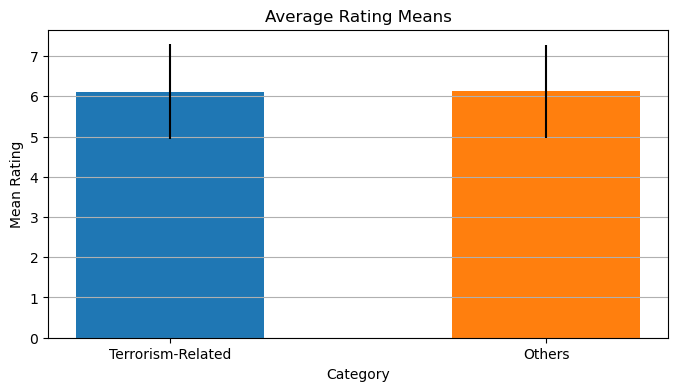

In [25]:
means= [mean_terror_rating, mean_other_rating]
stds= [std_terror_rating,std_other_rating]
cat= ['Terrorism-Related', 'Others']

fig, ax= plt.subplots(figsize= (8,4))
for i in range(2):   
    plt.bar(cat[i], means[i], yerr= stds[i], width=0.5)
    
plt.ylabel('Mean Rating')
ax.yaxis.grid(True)
plt.xlabel('Category')
plt.title('Average Rating Means')
plt.show()
plt.show()

In [26]:
other_merged['averageRating'].describe()

count    35912.000000
mean         6.123137
std          1.152253
min          1.000000
25%          5.500000
50%          6.200000
75%          6.900000
max          9.900000
Name: averageRating, dtype: float64

In [27]:
terrorism_merged['averageRating'].describe()

count    5543.000000
mean        6.117644
std         1.175137
min         1.200000
25%         5.400000
50%         6.300000
75%         6.900000
max         9.900000
Name: averageRating, dtype: float64

#### 4.2 Are there noticeable **topic patterns** in terrorism movies? Do terrorism movies tend to focus on specific themes? If they do, do different countries or regions portray different themes in their cinematic representation of terrorism?

In [28]:
df_plot = m_plot.rename(columns={0: 'W_movie ID', 1: 'summary'})
df_for_topics = pd.merge(terrorism_movies, df_plot, on='W_movie ID', how='inner')
df_for_topics.drop('Box office revenue', axis =1, inplace=True)
df_for_topics.head(3)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary
0,32986669,Robbery Under Arms,1907,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",Key scenes of the film included the branding o...
1,7870349,Dr. Jekyll and Mr. Hyde,1908,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Dr. Jekyll and Mr. Hyde began with the raising...
2,29391146,The Black Viper,1908,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film""}",A thug accosts a girl as she leaves her workpl...


**In this section we remove all rows containing null values for Countries as I will be an essential tool in our computation**



In [29]:
contains_empty_json = df_for_topics['Countries'].apply(is_empty_json)
filtered_df_for_topics = df_for_topics[~contains_empty_json]
filtered_df_for_topics.shape[0]

7934

#### 4.2.1  Number of movies per country

**Now we would like to see how many different countries we can find in our data set in order to check if we can classify the movies per country.**

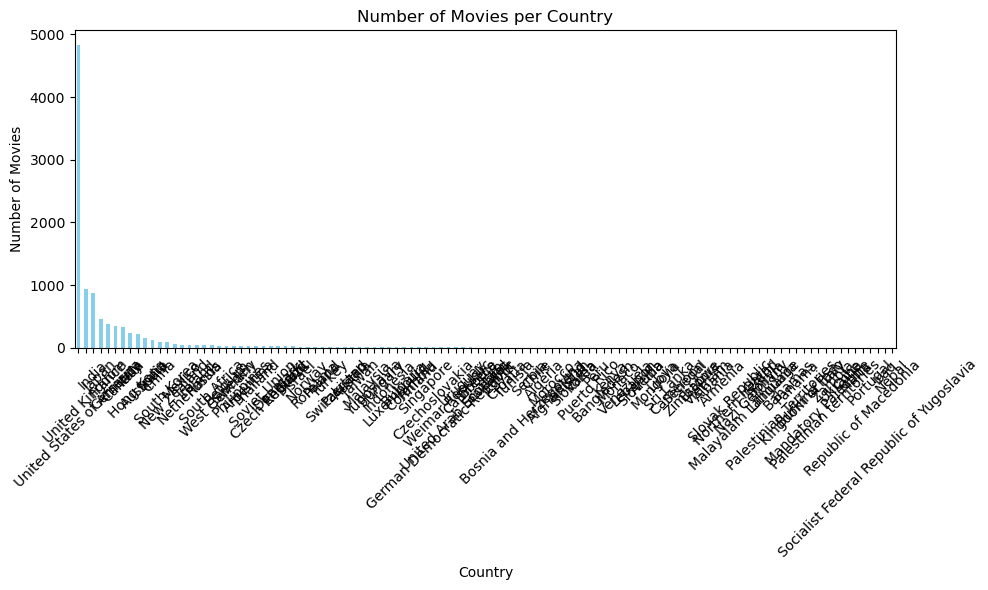

In [30]:
unique_countries = []
for countries_str in filtered_df_for_topics['Countries']:
    unique_countries.extend(extract_countries(countries_str))
# Count the occurrences of each country
country_counts = pd.Series(unique_countries).value_counts()
# Plotting
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Country')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**We notice that classifying movies per country is not efficient as there is an imbalanced number of movies per country thus we decided to do a classification per region.**

#### 4.2.2 Number of movies per region

**Data set for regions:** https://www.itu.int/en/ITU-D/Statistics/Pages/definitions/regions.aspx 


In [31]:
df_regions = pd.read_excel('data/Countries_Region.xlsx')
dfs = []
new_df_regions = pd.DataFrame(['Country, Region'])
for i in df_regions.columns:
    region_name = i
    # Create a DataFrame for each region with 'Country' and 'Region' columns
    temp_df = pd.DataFrame({'Country': df_regions[i].dropna(), 'Region': region_name})
    
    # Append each region DataFrame to the list
    dfs.append(temp_df)
new_df_regions = pd.concat(dfs, ignore_index=True)

In [32]:
# Extract unique values from the renamed columns
countries_list = []
for column in df_regions.columns:
        countries_list.extend(df_regions[column].unique().tolist())
unique_countries = set(unique_countries)
countries_not_in_list = [country for country in unique_countries if country not in countries_list]

# Display the list of countries not contained in the 'unique_countries_list'
print("Countries not contained in the unique list:")
print(len(countries_not_in_list))

Countries not contained in the unique list:
31


We noticed that in this data set some countries are not mapped to regions thus we will map them manually:

In [33]:
country_to_region = {
    'United States of America': 'America',
    'West Germany': '​Europ Region',
    'Scotland': '​Europ Region',
    'Taiwan': 'Asia and Pacific',
    'South Korea': 'Asia and Pacific',
    'Monaco': '​Europ Region',
    'Weimar Republic': '​Europ Region',
    'Nepal': 'Asia and Pacific',
    'Iran': '​Arab States',
    'Soviet Union': 'Cis',
    'Nazi Germany': '​Europ Region',
    'Aruba': 'America',
    'Kingdom of Italy': '​Europ Region',
    'Palestinian Territories': '​Arab States',
    'Russia': 'Cis',
    'England': '​Europ Region',
    'Yugoslavia': '​Europ Region',
    'Puerto Rico': 'America',
    'Palestinian territories': '​Arab States',
    'Vietnam': 'Asia and Pacific',
    'Hong Kong': 'Asia and Pacific',
    'Socialist Federal Republic of Yugoslavia': '​Europ Region',
    'Bolivia': 'America',
    'Korea': 'Asia and Pacific',
    'Slovak Republic': '​Europ Region',
    'Malayalam Language': 'Asia and Pacific',
    'Republic of Macedonia': '​Europ Region',
    'Czechoslovakia': '​Europ Region',
    'Mandatory Palestine': '​Arab States',
    'German Democratic Republic': '​Europ Region',
    'Northern Ireland': '​Europ Region'
}

In [36]:
country_to_region_df = pd.DataFrame(country_to_region.items(), columns=['Country', 'Region'])
final_df_regions = pd.concat([country_to_region_df, new_df_regions], ignore_index=True)
filtered_df_for_topics['Country_extract'] = filtered_df_for_topics['Countries'].apply(extract_countries_from_dictionary)

def map_region(country_list):
    return final_df_regions[final_df_regions['Country'].isin(country_list)]['Region'].tolist()

# Apply the function to create a new column 'Region' in filtered_df_for_topics
filtered_df_for_topics['Region'] = filtered_df_for_topics['Country_extract'].apply(map_region)

/var/folders/67/6c4p9l3d6gz7mdpq5tr7rk7w0000gn/T/ipykernel_3768/2816954137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_for_topics['Country_extract'] = filtered_df_for_topics['Countries'].apply(extract_countries_from_dictionary)
/var/folders/67/6c4p9l3d6gz7mdpq5tr7rk7w0000gn/T/ipykernel_3768/2816954137.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_for_topics['Region'] = filtered_df_for_topics['Country_extract'].apply(map_region)


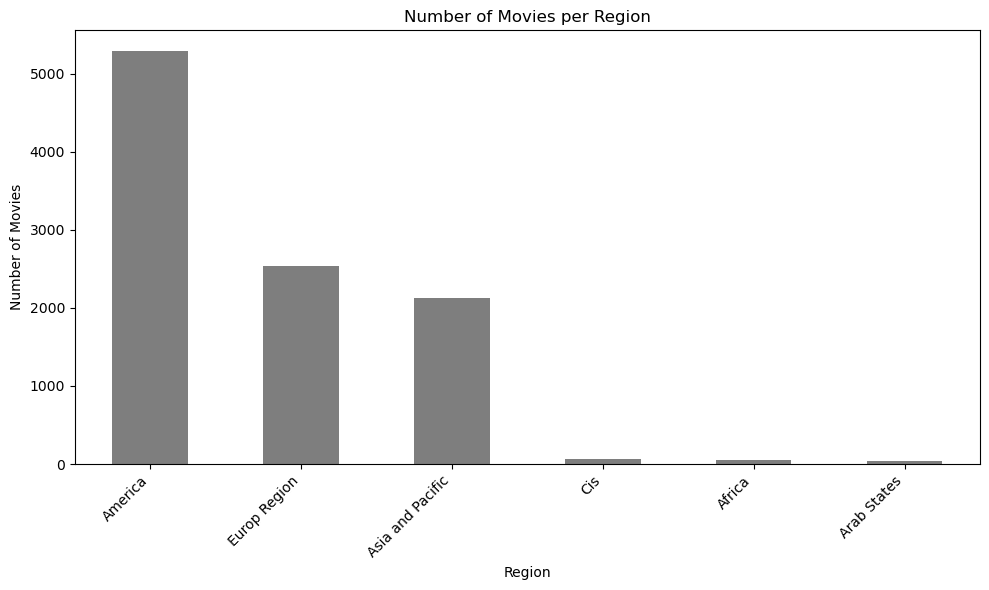

In [37]:
flattened_regions = filtered_df_for_topics['Region'].explode()
movies_per_region = flattened_regions.value_counts()
# Plot the number of movies per region
plt.figure(figsize=(10, 6))
movies_per_region.plot(kind='bar', color='#7e7e7e')
plt.title('Number of Movies per Region')
plt.xlabel('Region')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [38]:
print("Count of movies per region:")
print(movies_per_region)

Count of movies per region:
America             5292
​Europ Region       2538
Asia and Pacific    2121
Cis                   67
Africa                48
​Arab States          34
Name: Region, dtype: int64


In [39]:
import plotly.express as px

# Sort the DataFrame by 'Release date'

exploded_df = filtered_df_for_topics.explode('Region').sort_values('Release date')
exploded_df['Release date'] = pd.to_datetime(exploded_df['Release date']).dt.year

# Create a DataFrame suitable for Plotly
plotly_df = exploded_df.groupby(['Region', 'Release date']).size().reset_index(name='Number of Movies')
# Interactive Plot
fig = px.line(plotly_df, x='Release date', y='Number of Movies', color='Region',
              title='Interactive Plot of Movies per Year for Each Region',
              labels={'Release date': 'Release Year', 'Number of Movies': 'Count'})

fig.update_xaxes(rangeslider_visible=True)
fig.show()

We can notive here that there are not enough movies to make an analysis for CIS region, Arab States and Africa thus we will do our topic modelling analysis on the other three region.

#### 4.2.3 Number of movies per release date for each region

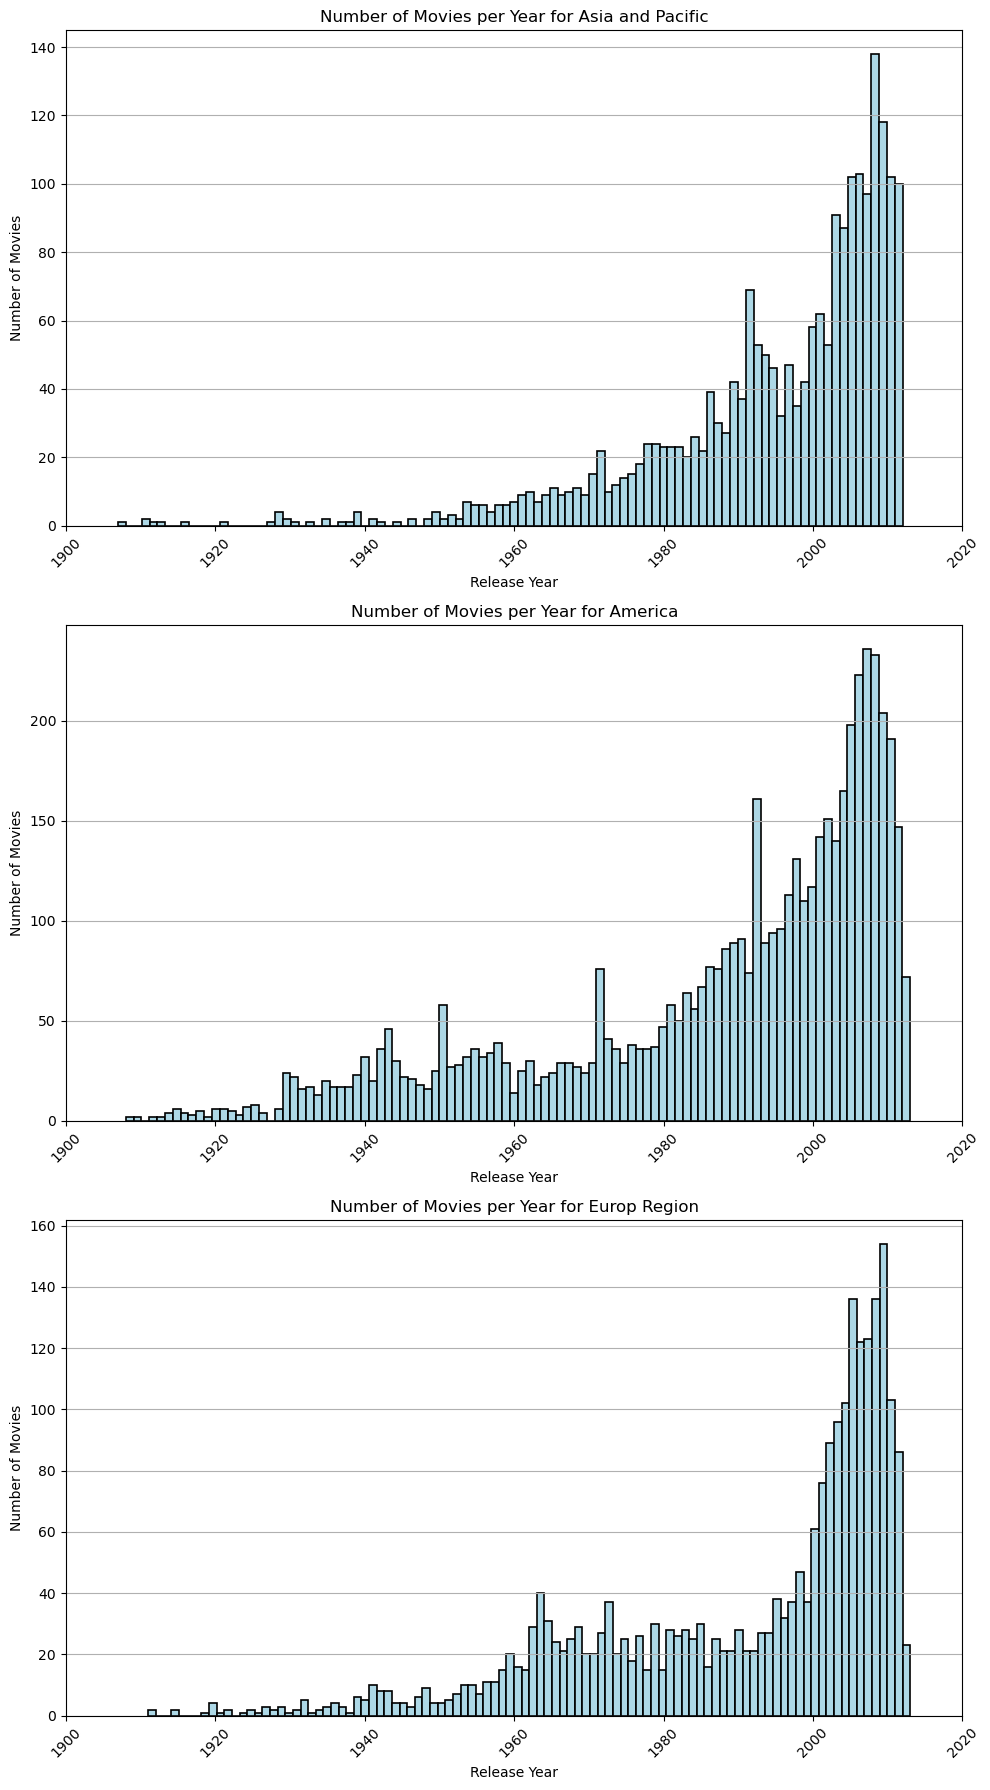

In [49]:
movies_per_year_per_region = (exploded_df.groupby(['Region', 'Release date'])
                                        .size()
                                        .unstack(fill_value=0))
unique_regions = exploded_df['Region'].unique()[:3]
fig, axes = plt.subplots(nrows=len(unique_regions), figsize=(10, 6 * len(unique_regions)))


for i, region in enumerate(unique_regions):
    # Select data for the current region
    region_data = exploded_df[exploded_df['Region'] == region]['Release date'].sort_values()
    axes[i].hist(region_data, bins=100, linewidth=1.2, edgecolor='black', color='lightblue')
    axes[i].set_xlabel('Release Year')
    axes[i].set_ylabel('Number of Movies')
    axes[i].set_title(f'Number of Movies per Year for {region}')
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()
    

### **.3 Genre association: Are there specific genres associated to terrorism movies?**

### **2.4 Emotional depiction: How do movies emotionally depict terrorism, and are there identifiable patterns in the portrayal of emotions like fear, anger, empathy, or sadness? Additionally, do the emotional tones in the cinematic representation of terrorism differ between specific countries/regions?**